**This is the final project in Data Analysis.**

Goals:
1. Analyze the cryptocurrency market in the selected time period
2. Try to predict the results of exchange rates (without focusing on events)
3. Analyze current profitability and risk
4. Prepare forecasted financial statements
5. Analyze the share of cryptocurrencies in the economy

Description of variables

* slug - unique name of cryptocurrency (text)
* symbol - unique short name (text)
* name - name of cryptocurrency (text)
* date - dates (categorical)
* ranknow - market entry (ordinal)
* open - starting bid price (numerical)
* high - highest bid price (numerical)
* low - lowest bid price (numerical)
* close - closing bid price (numerical)
* volume - number of transactions (quantitative)
* market - market capitalization (numerical)
* close_ration - difference between open and close price (numerical)
* spread - difference between the lowest and the highest price (numerical)

In [20]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import datetime as dt
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt

import plotly.express as px
from plotly import tools
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go

import xgboost as xgb

from sklearn.linear_model import LinearRegression as LinReg
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

Read the data and drop the symbols

In [3]:
df = pd.read_csv("crypto-markets.csv")

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 942297 entries, 0 to 942296
Data columns (total 13 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   slug         942297 non-null  object 
 1   symbol       942297 non-null  object 
 2   name         942297 non-null  object 
 3   date         942297 non-null  object 
 4   ranknow      942297 non-null  int64  
 5   open         942297 non-null  float64
 6   high         942297 non-null  float64
 7   low          942297 non-null  float64
 8   close        942297 non-null  float64
 9   volume       942297 non-null  float64
 10  market       942297 non-null  float64
 11  close_ratio  942297 non-null  float64
 12  spread       942297 non-null  float64
dtypes: float64(8), int64(1), object(4)
memory usage: 93.5+ MB


In [5]:
df.describe()

,ranknow,open,high,low,close,volume,market,close_ratio,spread
count,942297.000000,9.422970e+05,9.422970e+05,9.422970e+05,9.422970e+05,9.422970e+05,9.422970e+05,942297.000000,9.422970e+05
mean,1000.170608,3.483522e+02,4.085930e+02,2.962526e+02,3.461018e+02,8.720383e+06,1.725060e+08,0.459499,1.123400e+02
std,587.575283,1.318436e+04,1.616386e+04,1.092931e+04,1.309822e+04,1.839802e+08,3.575590e+09,0.326160,6.783713e+03
min,1.000000,2.500000e-09,3.200000e-09,2.500000e-10,2.000000e-10,0.000000e+00,0.000000e+00,-1.000000,0.000000e+00
25%,465.000000,2.321000e-03,2.628000e-03,2.044000e-03,2.314000e-03,1.750000e+02,2.958100e+04,0.162900,0.000000e+00
50%,1072.000000,2.398300e-02,2.680200e-02,2.143700e-02,2.389200e-02,4.278000e+03,5.227960e+05,0.432400,0.000000e+00
75%,1484.000000,2.268600e-01,2.508940e-01,2.043910e-01,2.259340e-01,1.190900e+05,6.874647e+06,0.745800,3.000000e-02
max,2072.000000,2.298390e+06,2.926100e+06,2.030590e+06,2.300740e+06,2.384090e+10,3.265025e+11,1.000000,1.770563e+06


In [6]:
dfnum = df.drop(['slug', 'symbol', 'name', 'date'], axis=1)

In [7]:
dfnum.mean()  # Mean value

ranknow        1.000171e+03
open           3.483522e+02
high           4.085930e+02
low            2.962526e+02
close          3.461018e+02
volume         8.720383e+06
market         1.725060e+08
close_ratio    4.594995e-01
spread         1.123400e+02
dtype: float64

In [8]:
df_range = pd.DataFrame(dfnum.max() - dfnum.min()).T
df_range  # Data range

,ranknow,open,high,low,close,volume,market,close_ratio,spread
0,2071.0,2298390.0,2926100.0,2030590.0,2300740.0,2.384090e+10,3.265025e+11,2.0,1770563.0


In [9]:
dfnum.std()  # Standard deviation

ranknow        5.875753e+02
open           1.318436e+04
high           1.616386e+04
low            1.092931e+04
close          1.309822e+04
volume         1.839802e+08
market         3.575590e+09
close_ratio    3.261605e-01
spread         6.783713e+03
dtype: float64

In [10]:
dfnum.std() ** 2  # Dispersion is squared degree of standard deviation

ranknow        3.452447e+05
open           1.738273e+08
high           2.612703e+08
low            1.194499e+08
close          1.715634e+08
volume         3.384870e+16
market         1.278484e+19
close_ratio    1.063807e-01
spread         4.601876e+07
dtype: float64

In [11]:
df.isnull().sum()  # Checking NULLs, we're lucky

slug           0
symbol         0
name           0
date           0
ranknow        0
open           0
high           0
low            0
close          0
volume         0
market         0
close_ratio    0
spread         0
dtype: int64

In [12]:
dfnums = df.drop(['spread'], axis=1)

In [15]:
def three_sigma(dataframe):  # Three sigma rule, and it looks too bad
    ejects = (abs(dataframe - dataframe.mean()) > 3 * dataframe.std()).sum()
    dfeject = pd.DataFrame(ejects)
    percentage = pd.DataFrame((ejects / dataframe.count()) * 100)
    return dfeject, percentage

In [16]:
three_sigma(dfnum)

(                0
 ranknow         0
 open         1078
 high         1056
 low          1099
 close        1077
 volume       2423
 market       2187
 close_ratio     1
 spread        661,
                     0
 ranknow      0.000000
 open         0.114401
 high         0.112067
 low          0.116630
 close        0.114295
 volume       0.257138
 market       0.232092
 close_ratio  0.000106
 spread       0.070148)

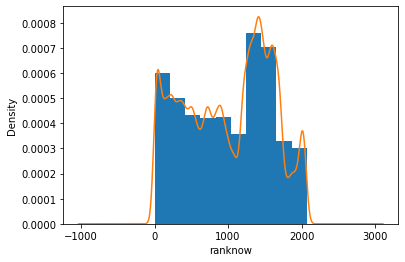

In [24]:
df['ranknow'].hist(density = "True")
plt.xlabel('ranknow')
df['ranknow'].plot.kde()

In [ ]:
import scipy.stats as s

def weib(x, n, a): 
    return (a / n) * (x / n) ** (a - 1) * np.exp(-(x / n) ** a)

data = df

(loc, scale) = s.exponweib.fit_loc_scale(data, 1, 1)
print(loc, scale)

x = np.linspace(data.min(), data.max(), 1000)

plt.plot(x, weib(x, loc, scale))
plt.hist(data, data.max(), normed=True)
plt.show()

In [ ]:
df = df.drop(['slug'], axis=1)  # Drop useless columns

df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')  # Transform date to date object

In [ ]:
df.head(10)

Traders still love to analyze the concept of HLC (and OHLC|HL) [proof](https://www.mypivots.com/dictionary/definition/92/hlc-3)

In [ ]:
df['ohlc_average'] = (df['open'] + df['high'] + df['low'] + df['close']) / 4

Checking other currencies

In [ ]:
top10 = df[(df['ranknow'] >= 1) & (df['ranknow'] <= 10)]
top10.name.unique()

*Volume* - All trades buys and sells that were made during that time (for example 24 hours like coinmarketcap does by default).

*Circulating supply* - number of coins mined and existing right now.

*Marketcap* = circulating supply multiply by price of coin.

In [ ]:
fig = px.pie(top10, values='volume', names='name', title='Cryptocurrencies Top-10 by Transaction Volume')
fig.show()

In [ ]:
fig = px.pie(top10, values='market', names='name', title='Cryptocurrencies Top-10 by Market capitalization')
fig.show()

In [ ]:
fig = tools.make_subplots(subplot_titles=('Time'))
for name in top10.name.unique():
    currency = top10[top10['name'] == name]
    trace = go.Scatter(x=currency['date'], y=currency['ohlc_average'], name=name)
    fig.append_trace(trace, 1, 1)
    
fig['layout'].update(title='Top-10 Cryptocurrencies Comparison')
fig['layout']['yaxis1'].update(title='USD')
fig.show()

Adding minor cryptocurrencies that not affect too much on the market

In [ ]:
top10minorCurrencies = df[(df['ranknow'] >= 11) & (df['ranknow'] <= 21)]

top10minorCurrencies.name.unique()

In [ ]:
fig = px.pie(top10minorCurrencies, values='volume', names='name', title='Minor Cryptocurrencies by Transaction Volume')
fig.show()

In [ ]:
fig = px.pie(top10minorCurrencies, values='market', names='name', title='Minor Cryptocurrencies by Market capitalization')
fig.show()

In [ ]:
top10loserCoins = df[(df['ranknow'] >= max(df['ranknow']) - 10) & (df['ranknow'] <= max(df['ranknow']))]

top10loserCoins.name.unique()

In [ ]:
fig = px.pie(top10loserCoins, values='volume', names='name', title='Loser Cryptocurrencies by Transaction Volume')
fig.show()

In [ ]:
fig = px.pie(top10loserCoins, values='market', names='name', title='Loser Cryptocurrencies by Market capitalization')
fig.show()